In [1]:
import sqlite3
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pandas as pd
import matplotlib.pyplot as plt
import random
% matplotlib inline

# Pipeline using cleaned data

In [2]:
store = pd.HDFStore('store.h5')

In [3]:
members = store['members']

In [4]:
training = pd.read_csv('data/churn_comp_refresh/train_v2.csv')

In [5]:
sample_submission = pd.read_csv('data/churn_comp_refresh/sample_submission_v2.csv')

In [25]:
# select only the intersection between training and members tables
members_training = members.merge(training, on='msno', how='inner')

In [6]:
members_training.head()

,msno,age,age_is_null,gender_is_null,days_since_start_of_membership,city_1,city_3,city_4,city_5,city_6,...,city_21,city_22,gender_female,gender_male,registered_via_3,registered_via_4,registered_via_7,registered_via_9,registered_via_13,is_churn
0,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,-1,1,1,2056,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,I0yFvqMoNkM8ZNHb617e1RBzIS/YRKemHO7Wj13EtA0=,63,0,0,2052,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
2,OoDwiKZM+ZGr9P3fRivavgOtglTEaNfWJO4KaJcTTts=,-1,1,1,2052,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,4De1jAxNRABoyRBDZ82U0yEmzYkqeOugRGVNIf92Xb8=,28,0,0,2050,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
4,Z6WIOK9vXy+e2XDBiioNAxuZ0ScXSU/Ebq4tUwqVSrE=,38,0,0,2041,0,0,0,0,0,...,0,1,1,0,0,0,0,1,0,0


In [26]:
X = np.array(members_training.iloc[:, 1:-1])
X_columns = members_training.iloc[:, 1:-1].columns
y = np.array(members_training.iloc[:, -1])

In [9]:
# what is the base rate for churn?
print('The null error rate is {:.2f}%'.format(y.mean()*100))

The null error rate is 1.87%


In [10]:
sum(y)/len(y)

0.018726447193105854

with such a low base rate, we could predict accurately 98% the time by always predicting 'does not churn'

In [65]:
BASE_RATE = sum(training['is_churn'])/len(training)
print('base rate in the training set: {:.2f}%'.format(BASE_RATE * 100))


base rate in the training set: 8.99%


when we excluded all the training rows that aren't in members, we massively decreased the 
base rate in the training set

In [27]:
# instantiate a logistic regression model, and fit with X and y
model = LogisticRegression()
model = model.fit(X, y)

# check the accuracy on the training set
model.score(X, y)

0.9812735528068941

In [13]:
# examine the coefficients
pd.DataFrame(list(zip(X_columns, np.transpose(model.coef_))))

,0,1
0,age,[-0.0379273087058]
1,age_is_null,[-1.33576086956]
2,gender_is_null,[-0.480291965725]
3,days_since_start_of_membership,[-5.05706358211e-05]
4,city_1,[0.106642197472]
5,city_3,[-0.17697335978]
6,city_4,[-0.113399308267]
7,city_5,[-0.11134750185]
8,city_6,[-0.0629131880577]
9,city_7,[0.119378363107]


### Model evaluation

In [28]:
# evaluate the model by splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
model2 = LogisticRegression()
model2.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [29]:
# get the prediction probabilities, rather than the class
predicted_probabilities = model2.predict_proba(X_test)

In [30]:
predicted_probabilities

array([[ 0.99516966,  0.00483034],
       [ 0.94406778,  0.05593222],
       [ 0.99514916,  0.00485084],
       ..., 
       [ 0.99517411,  0.00482589],
       [ 0.92904861,  0.07095139],
       [ 0.96181154,  0.03818846]])

In [31]:
X_test

array([[-1,  1,  1, ...,  1,  0,  0],
       [25,  0,  0, ...,  0,  0,  0],
       [-1,  1,  1, ...,  1,  0,  0],
       ..., 
       [-1,  1,  1, ...,  1,  0,  0],
       [-1,  1,  1, ...,  0,  0,  0],
       [33,  0,  0, ...,  0,  0,  0]])

In [49]:
def roc_curve(model, X_test):
    # get the prediction probabilities, rather than the class
    predicted_probabilities = model2.predict_proba(X_test)
    y_score = predicted_probabilities[:, 1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr) # compute area under the curve
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for {}'.format(model))
    plt.legend(loc="lower right")
    
    # create the axis of thresholds (scores)
    ax2 = plt.gca().twinx()
    ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='r')
    ax2.set_ylabel('Threshold',color='r')
    ax2.set_ylim([thresholds[-1],thresholds[0]])
    ax2.set_xlim([fpr[0],fpr[-1]])

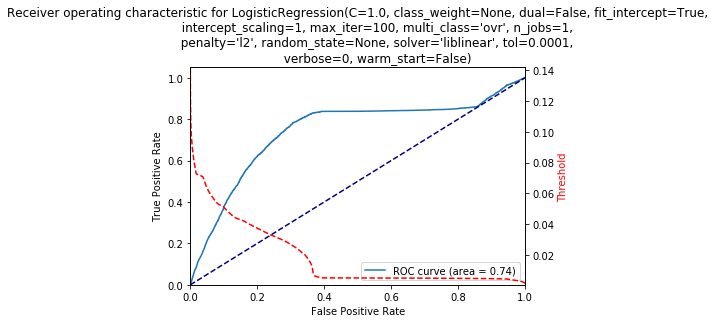

In [50]:
roc_curve(model2, X_test)

TODO: Stratified Cross-validation

### Produce output

In [16]:
# select only the intersection between training and members tables
members_submission = members.merge(sample_submission.drop('is_churn', 1), on='msno', how='inner')

In [17]:
members_submission.head()

,msno,age,age_is_null,gender_is_null,days_since_start_of_membership,city_1,city_3,city_4,city_5,city_6,...,city_20,city_21,city_22,gender_female,gender_male,registered_via_3,registered_via_4,registered_via_7,registered_via_9,registered_via_13
0,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,-1,1,1,2056,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,WFLY3s7z4EZsieHCt63XrsdtfTEmJ+2PnnKLH5GY4Tk=,32,0,0,2055,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
2,I0yFvqMoNkM8ZNHb617e1RBzIS/YRKemHO7Wj13EtA0=,63,0,0,2052,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,OoDwiKZM+ZGr9P3fRivavgOtglTEaNfWJO4KaJcTTts=,-1,1,1,2052,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,4De1jAxNRABoyRBDZ82U0yEmzYkqeOugRGVNIf92Xb8=,28,0,0,2050,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0


In [21]:
submit_X = np.array(members_submission.iloc[:, 1:])
submit_y = model2.predict_proba(submit_X)[:,1]

In [72]:
np.array(members_submission['msno'])

array(['+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=',
       'WFLY3s7z4EZsieHCt63XrsdtfTEmJ+2PnnKLH5GY4Tk=',
       'I0yFvqMoNkM8ZNHb617e1RBzIS/YRKemHO7Wj13EtA0=', ...,
       'O11rAa17ANM6DGMMVb9L2vwCQFv/S6SR3SDB1nGuOAc=',
       'tyoRqQ72Y2oCcqvdaIxG8T0Hs9DZvuuM8IeTwhxtdBQ=',
       'nWjH7glPkZ7jOVaCRwwjlpmp0T1hSWdv8hMJxiWCwKc='], dtype=object)

In [89]:
submission = np.array((np.array(members_submission['msno']), submit_y)).T

In [62]:
# since 112381 test users are missing from the members table, use base rate for these
missing_users = np.array(list(set(sample_submission.msno) - set(members.msno)))
len(missing_users)

112381

In [91]:
submission_missing = np.array((missing_users, np.full(112381, BASE_RATE))).T

In [108]:
# Write to CSV
final_submission = np.concatenate((submission, submission_missing))
pd.DataFrame(final_submission, columns = sample_submission.columns)\
    .to_csv('/Users/lintaylor/DueDil/ten_percent/kaggle_churn/14122017_01.csv', header=True, index=False)